This notebook is used to test the idea of uing a convex combiantion of Runge Kutta methods to get the final result.

For this approach the implicit solver is adventagious because at least the backward euler method yields to an positive result.
This enshures that at least one point of the convex combination is positive.

The idea is to have multiple $b_i$ for $d$ methods, that all can be computed with one $A$. 

This has the advantage of enshuring the solution is does not get worse than the solution of the backward euler method. (A good example for comparison is the Diffusion with an Dirca as initial  condition)

The optimisation problem is changed to:

$$u_{n+1}=u_n+\Delta K \vec{b} \geq 0$$

with

$$ \vec{b} = \sum_i^d a_i \vec{b_i}$$

$$ \forall_{i \in \{1, \cdots d \}} 0 \leq a_1 \leq 1$$

and the objective

$$ min \left(\sum_i^d w_i a_i \right) $$

with some weighting factors $w_1,\cdots,w_d$. The weighting factors determine which is the prefered b to use.

Because we want that the optimal soultion is the origianl $b$ the weight $w_0$ corresponding to $b_{orig}$ should be the smalest $w$. We could just set this $w$ to $0$.
For implicit methods with $s \geq p$ we would still like to have some degrees of fredum for the highest order. For this we have to intoduce at least one $b$ that complies with the order Condition for the Order and $b \neq b_{orig}$. 

If we reduce the Order we can intoduce new $b$ that do not complie the Order Conditons (This is an easy task for the first Order because we have to choose a method that ensures positifity but is not so clear cut for the intermediate Orders)

What would be good objectives for choosing the $b$ od Order $> 1$?:
Small negative b?
Small error coefficents?


We also have to make sure that all used $b$ define A-Stable methods, because this ensures that the final method is alos A-Stable

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nodepy import rk
import cvxpy as cp


import numpy.linalg as linalg


#Diagonally Implicit methods:
BE = rk.loadRKM('BE').__num__()
SDIRK23 = rk.loadRKM('SDIRK23').__num__()
SDIRK34 = rk.loadRKM('SDIRK34').__num__()
SDIRK54 = rk.loadRKM('SDIRK54').__num__()
TR_BDF2 = rk.loadRKM('TR-BDF2').__num__()


be = rk.loadRKM('BE').__num__()

#Extrapolation method
ex2 = rk.extrap(2,'implicit euler').__num__()
ex3 = rk.extrap(3,'implicit euler').__num__()
ex4 = rk.extrap(4,'implicit euler').__num__()
ex5 = rk.extrap(5,'implicit euler').__num__()
ex6 = rk.extrap(6,'implicit euler').__num__()
ex8 = rk.extrap(8,'implicit euler').__num__()


from OrderCondition import *
from RKimple import *
import utils 
import scipy.linalg 

In [2]:
print(ex2)
print(ex3)

Im-Euler 2

 1.000 | 1.000
 0.500 |        0.500
 1.000 |        0.500  0.500
_______|_____________________
       |-1.000  1.000  1.000
Im-Euler 3

 1.000 | 1.000
 0.500 |        0.500
 1.000 |        0.500  0.500
 0.333 |                      0.333
 0.667 |                      0.333  0.333
 1.000 |                      0.333  0.333  0.333
_______|__________________________________________
       | 0.500 -2.000 -2.000  1.500  1.500  1.500


# Adding the embeded Methods

We want to get new methods that complie with the Order Conditions. Thsi can be done by getting the vectors that span the Kernel of the Order Condition MAtrix $Q$. This vectors can then be weighted and added to the original $b$. By this the Order Conditions are still satisfied. 

As last step we test if the gerneated method is still A-Stable 


Note on the Implementation:
We use the Attribute A-hat of the rkm class to store the embeded emthods. We give it as a dict for the different Orders.

In [3]:
Q,rhs = OrderCond(ex3.A,ex3.c,order = 3)
scipy.linalg.null_space(Q)

array([[ 0.18666164,  0.12726036],
       [-0.67656634,  0.32929767],
       [-0.40836339, -0.67369028],
       [ 0.25371238, -0.12348663],
       [ 0.50742476, -0.24697325],
       [ 0.13713096,  0.58759213]])

The stability region is unbounded
The stability region is unbounded
The stability region is unbounded
The stability region is unbounded


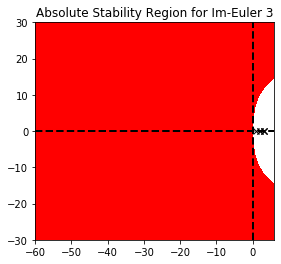

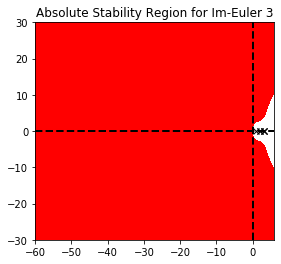

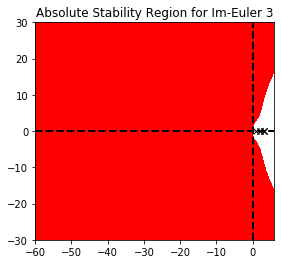

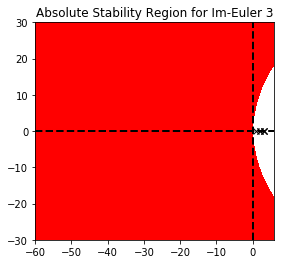

In [4]:
#thsi is probably not the optimal way but it still gives all possible options
span = scipy.linalg.null_space(Q)
scale = 2
ex3 = rk.extrap(3,'implicit euler').__num__()
b_orig = ex3.b
b_hat_3 = []
for i in range(span.shape[1]):
    for s in {-1,+1}:
        ex3.b = b_orig+ scale*s*span[:,i]
        b_hat_3.append(ex3.b)
        ex3.plot_stability_region()



array([-0.24547928,  2.65859534,  0.65261944, -1.44697325, -1.69394651,
       -0.02481574])

array([[ 1.21624684e+00, -2.44155127e-01, -1.74483514e+00,
         5.43257754e-02,  2.57581139e-01,  4.60836503e-01],
       [-2.44155127e-01,  4.90128514e-02,  3.50266433e-01,
        -1.09056123e-02, -5.17080525e-02, -9.25104927e-02],
       [-1.74483514e+00,  3.50266433e-01,  2.50315112e+00,
        -7.79360884e-02, -3.69527472e-01, -6.61118856e-01],
       [ 5.43257754e-02, -1.09056123e-02, -7.79360884e-02,
         2.42655501e-03,  1.15053085e-02,  2.05840619e-02],
       [ 2.57581139e-01, -5.17080525e-02, -3.69527472e-01,
         1.15053085e-02,  5.45514618e-02,  9.75976152e-02],
       [ 4.60836503e-01, -9.25104927e-02, -6.61118856e-01,
         2.05840619e-02,  9.75976152e-02,  1.74611169e-01]])

Test if Order condition are still mett


array([-1.55431223e-15, -4.44089210e-16])

New b of second Order


array([-2.36727974, -2.13409778,  3.09566057,  1.63026984,  1.44060699,
       -0.66515988])

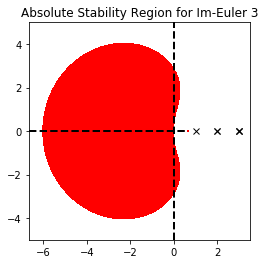

In [5]:
#as the seccond order method we try projecting the first oder method on the order conditions 
#but we will provbably need something better here
db = np.array([0,0,0,0.3,0.3,0.3]) -ex3.b
display(db)
Q,rhs = OrderCond(ex3.A,ex3.c,order = 2)
S = scipy.linalg.null_space(Q)
#construct proj. Matrix
proj = np.zeros([S.shape[0],S.shape[0]])
for i in range(S.shape[1]):
    s = S[:,0]
    s.shape = (len(s),1)
    proj += s@s.T
display(proj)
b_proj = proj@db + ex3.b
print('Test if Order condition are still mett')
display(Q@b_proj-rhs)
print('New b of second Order')
display(b_proj)

ex3.b = b_proj
ex3.plot_stability_region();
#apparenty that does not work...

The stability region is unbounded


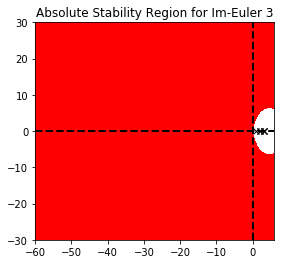

In [6]:
#some guess instead [-1/2,-1,-1/2,1,1,1]
ex3.b = np.array([-1/2,-1,-1/2,1,1,1])
ex3.plot_stability_region();

b_hat_2 = [np.array([-1/2,-1,-1/2,1,1,1])]

The stability region is unbounded


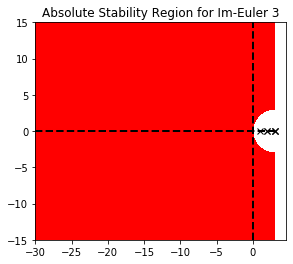

In [7]:
#The first Order method that ensures posifitifity
ex3.b = np.array([0,0,0,1/3,1/3,1/3])
ex3.plot_stability_region();

b_hat_1 = [np.array([0,0,0,1/3,1/3,1/3])]

In [8]:
ex3 = rk.extrap(3,'implicit euler').__num__()
ex3.b_hat = {3:b_hat_3,2:b_hat_2,1:b_hat_1}

## Weights

It remains the question on what weights to use. 
We already set $w_0 = 0$ for the other weights we use $w_i = \frac{1}{Order\{b_i\}}$

In [9]:

def solve_LP_convex(solver,B,w,rkm,u,K,dt,reduce = False,verbose_LP = False,minval = 0,maxval=np.infty, **options): 
    """
    This method solves the LP Problem
    
    Parameters:
    
    solver:     a string with the solver that should be used
    O:          Order condition matrix
    rhs:        Order condition right hand side
    
    reduce:     If set, the LP problem is first solved with a reduced set of constriants
    verbose_LP: prints additional messages
    minval:     Vector or scalar, is the minimum to enforce for solution. If not needed set to -inf
    maxval:     Vector or scalar, is the minimum to enforce for solution. If not needed set to inf
    options:    additional Options, are passed through to the used solver
    
    Returns:
    status: integer representing the status of the algorithm.
      For scipy
        0 : Optimization proceeding nominally.
        1 : Iteration limit reached.
        2 : Problem appears to be infeasible.
        3 : Problem appears to be unbounded.
        4 : Numerical difficulties encountered.
      For cvypy
        0 : Optimization proceeding nominally.
        2 : Problem appears to be infeasible.
        4 : Numerical difficulties encountered.
        5 : solver crashed
        6 : Trivial Problem
    l = Array with number of constraints
    b: found b, if solver failed rkm.b
    
    """
    s = len(rkm.b)
    k = K.shape[0] #Number of ODEs

    l = []

    #Filter for variables with boundarys
    if np.isscalar(minval):
        minval = np.repeat(minval,k)        
    if np.isscalar(maxval):
        maxval = np.repeat(maxval,k)
    
    i_n = minval > -np.infty
    i_p = maxval < np.infty


    i_min = np.zeros(k,bool)
    i_max = np.zeros(k,bool)
    if reduce: #We do not need it otherwise
        u_ = u +dt*K@rkm.b


    while True: #We check at the end for break conditions

        #Reduce
        if reduce:
            i_min[i_n] = i_min[i_n] | (u_[i_n] < minval[i_n])
            i_max[i_p] = i_max[i_p] | (u_[i_p] > maxval[i_p])
        
        else:
            i_min = i_n
            i_max = i_p

        if not np.any(i_min) and not np.any(i_max):
            print('trivial Problem')
            return (0,0,rkm.b)
        
        
        l.append(np.sum(i_min)+np.sum(i_max))

        #Solve LP-Problem

        u_min = u[i_min] #slice the u and K
        K_min = K[i_min,:]
        u_max = u[i_max] 
        K_max = K[i_max,:]
        minval_min = minval[i_min]
        maxval_max = maxval[i_max]

        if solver == 'scipy_ip' or solver == 'scipy_sim':
            raise NotImplementedError

        else:
            a_op = cp.Variable(len(w))
            e = np.ones(len(w)) 

            
            #Using different implementations to aviod empyt matricies
            if K_max.shape[0]>0 and K_min.shape[0]>0:
                prob = cp.Problem(cp.Minimize(w@a_op),
                    [e@a_op==1,
                    u_min+dt*K_min@B@a_op>=minval_min,
                    u_max+dt*K_max@B@a_op<=maxval_max,a_op>=0,a_op<=1])
            elif K_min.shape[0]>0:
                prob = cp.Problem(cp.Minimize(w@a_op),
                    [e@a_op==1,
                    u_min+dt*K_min@B@a_op>=minval_min,a_op>=0,a_op<=1])                
            elif K_max.shape[0]>0:
                prob = cp.Problem(cp.Minimize(w@a_op),
                    [e@a_op==1,
                    u_max+dt*K_max@B@a_op<=maxval_max,a_op>=0,a_op<=1])
            else:
                raise ValueError
                #should alredy be detected as trivial Problem
                
            try:
                prob.solve(solver=solver,**options)
                b = B@a_op.value
            except:
                if verbose_LP: print('Solver crashed')
                return (5,l,None)
            
            if prob.status == cp.OPTIMAL:
                status = 0
            elif prob.status == cp.OPTIMAL_INACCURATE:
                if verbose_LP: print(prob.status)
                status = 4
            else:
                status = 5
            

        #Test for break conditions
        if np.all(i_min == i_n) and np.all(i_max == i_p): #reached whole set 
            break
        u_ = u +dt*K@b
        if np.all(np.greater_equal(i_min,u_<minval)) and np.all(np.greater_equal(i_max,u_>maxval)): 
            #if there are no new negative values appearing
            break
    
    return (status,l,b)
 

In [10]:
def adapt_b_convex(rkm,K,dt,u,minval,maxval,tol_neg,tol_change,p,theta,solver,solveropts,verbose = False):
    """
    function to adapt the b to meke sure it complies with the boundaries
    Parameters:
    rkm:        RKM used
    K:          Matrix with stagevalues
    dt:         dt used to calculate the stagevalues
    u:          solution at timestep
    minval:     Minimum value
    maxval:     Maximum value
    tol_neg:    Which negativevalues are accepted for u
    tol_change: MAximum value for |K@(b-rkm.b)|_2 accepted
    p:          range of orders to try enforcing as iterabel
    theta:      factors of timesteps to try as iterable. Element of [0 to 1]^k
    solver:     solver to use
    solveropts: optins for the LP-Problem
    verbose:    Print additional messages

    return:
    success:     True if a new b could be found
    u_n:          u^{n+1}
    b:          The b used
    dt:         the dt used 
    message:    A status message as text
    status:     Status as dict

    """
    message = ''
    status = {}
    print('changed')

    for i,the in enumerate(theta): #loop through all the sub-timesteps
        for p_new in p:     #loop through orders

            if verbose: print('Try: Order=',p_new,'Theta=',the)
            #Construct Problem
            #Matrix with the used methods
            B = [[rkm.b]]
            w = [0]
            for order in range(rkm.p,p_new-1,-1):
                B.append(rkm.b_hat[order])
                w.extend([1/order]*len(rkm.b_hat[order]))
                
            B = np.concatenate(B).T
            if verbose: display(B)
            w = np.array(w)

            (status_LP,l,b) = solve_LP_convex(solver,B,w,rkm,u,K,dt,maxval = maxval,minval = minval,**solveropts)
            
            if status_LP in [2,3,5]:
                #Error Handling for didn not work
                if verbose:    print('LP-Solve failed, probably infeasibel')
            else: #Did work, testing further
                u_n = u + dt*K@b
                if not (np.all(u_n >= minval-tol_neg) and np.all(u_n <= maxval+tol_neg)) : 
                    #got a solution form the LP solver that is stil not positive...
                    #do some error handling here
                    if verbose:    print('LP-Solve returned a b that leads to a false solution')
                    if verbose >= 2:    print(min(u_n-minval)); print(max(u_n-maxval)); print(u_n)
                else:
                    change = np.linalg.norm(K@(b-rkm.b))
                    if change > tol_change: # to big adaption...
                        #do some error handling here
                        if verbose:    print('a to big adaptation to the solution by changing the b')
                        if verbose >= 2: print('|K(b_new-b)|=',change)
                    else: #we got a acceptable solution
                        if verbose: print('found new b')
                        return True, u_n,b, dt*the, message, change,p_new,the,status

    return False, None,np.zeros_like(rkm.b)*np.nan, 0, message, None, 0, 0,status


In [11]:

def RK_integrate_convex(solver = [], problem = [],dumpK=False,verbose=False):

    """    
    Options:
        solver: Solver Object with the fields:
            rkm:        Base Runge-Kutta method, in Nodepy format
            dt:         time step size
            t_final:    final solution time  
            b_fixed:    if True rkm.b are used
            tol_neg:    Which negativevalues are accepted for u
            tol_change: Maximum value for |K@(b-rkm.b)|_2 accepted
            p:          range of orders to try enforcing as iterabel
            theta:      factors of timesteps to try as iterable. Element of [0 to 1]^k
            solver:     the solver used for solving the LP Problem
            LP-opts:    Dict containing options for LP-solver
            solver_eqs: Solver for stageeqation for implicit method

        
        problem: Problem object with the fields:
            f:          RHS of ODE system
            u0:         Initial data
            minval:
            maxval:        Limits for Problem
                
        
        dumpK:      if True the stage values are also returned
        verbose:    if True function prints additional messages


    Returns:
        u:      Matrix with the solution
        t:      vector with the times
        b:      Matrix with the used b's

        if dumpK = True:
         K:     Array of the K Matrix containing the stagevalues
        if return_status
         status: dict containing
                'dt': the used dt
                'success': True if solver succeded, False if a inveasible or illdefined LP-Problem occured or the solver crashed
                'message': String containing more details
                'b':       Array with the indecies where b was changed
    """
    
    if not 'verbose_LP' in solver.LP_opts.keys():
        solver.LP_opts['verbose_LP'] = verbose


    #setup Variables for Soulution storage
    uu = [problem.u0]
    tt = [0]
    

    #setup Problem Solve
    explicit = solver.rkm.is_explicit()
    t = 0
    u = problem.u0
    dt= solver.dt

    #setup stepsize control
    dt_old = 1 #variable with the last tried dts


    success = True #For stepsize control at first step
    
    
    if dumpK:
        KK = ['null']


    #for debbugging bs
    bb = [solver.rkm.b]
        
    status = {
        'Solver':  solver,
        'Problem': problem,
        'success': True,
        'message': '',
        'neg_stage': [None],
        'LP_stat': [None],
        'b':[None],
        'change':[None],
        'old_min':[None],
        'new_min':[None],
        'old_max':[None],
        'new_max':[None],
        'order':[None],
        'theta':[None]
    }
    if verbose: print('set up, starting to solve')

    while t<solver.t_final:
        #Control new stepsize
        if t+dt > solver.t_final:
            dt = solver.t_final-t
        if not success:
            dt = 0.5 *dt_old
        if success:
            dt = solver.dt
        dt_old = dt    
        

        #Compute the new K
        if verbose: print('calculation new set of stagevalues for t =',t,'dt=',dt)
        if explicit:
            K,message,neg_stage = calculate_stages_exp(t,dt,u,solver.rkm,problem.f,verbose=verbose)
        else:
            K,message,neg_stage = calculate_stages_imp(t,dt,u,solver.rkm,problem.f,solver.solver_eqs,verbose=verbose)
        status['message'] += message
        status['neg_stage'].append(neg_stage)



        if dumpK:
            KK.append(K)
        
        #compute initial guess
        u_n = u +dt*K@solver.rkm.b

        if solver.b_fixed:
            u_n = u_n
            b = solver.rkm.b
            status['b'].append('o')
        else:
            if np.all(u_n >= problem.minval) and np.all(u_n <= problem.maxval):
                #everything is fine
                b = solver.rkm.b
                success = True
                status['b'].append('o')
                status['LP_stat'].append(None)
                status['change'].append(None)
                status['order'].append(None)
                status['theta'].append(None)
                status['old_min'].append(None)
                status['new_min'].append(None)
                status['old_max'].append(None)
                status['new_max'].append(None)
            else:
                status['old_min'].append(np.min(u_n - problem.minval))
                status['old_max'].append(np.max(u_n - problem.maxval))
                #if convex = False:
                #    success,u_n,b,dt,message, change, order, the,LP_stat = adapt_b(solver.rkm,K,dt,u,problem.minval,problem.maxval,
                #        solver.tol_neg,solver.tol_change,solver.p,solver.theta,solver.solver,solver.LP_opts,verbose = verbose)
                
                success,u_n,b,dt,message, change, order, the,LP_stat = adapt_b_convex(solver.rkm,K,dt,u,problem.minval,problem.maxval,
                        solver.tol_neg,solver.tol_change,solver.p,solver.theta,solver.solver,solver.LP_opts,verbose = verbose)
                
                status['b'].append('c')
                status['message'] += message
                status['LP_stat'].append(LP_stat)
                status['change'].append(change)
                status['order'].append(order)
                status['theta'].append(the)
                if success:
                    status['new_min'].append(np.min(u_n - problem.minval))
                    status['new_max'].append(np.max(u_n - problem.maxval))


            
        if success:
            if verbose: print('advancing t')
            t += dt
            u = u_n
        else:
            if verbose: print('step reqect')
            if solver.fail_on_requect:
                status['success'] = False
                status['b'][-1] = 'r'
                break
            else:
                status['b'][-1] = 'r'


        bb.append(b)
        uu.append(u)
        tt.append(t)

        
    ret = (status,tt,uu,bb)
    if dumpK:
        ret= ret + (KK,)

    
    return ret


set up, starting to solve
calculation new set of stagevalues for t = 0 dt= 0.0007847599703514606
Try: Order= 3 Theta= 1
Solver crashed
LP-Solve failed, probably infeasibel
Try: Order= 2 Theta= 1
found new b
advancing t
calculation new set of stagevalues for t = 0.0007847599703514606 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.0015695199407029213 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.002354279911054382 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.0031390398814058426 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.003923799851757303 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.004708559822108764 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.005493319792460225 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.006278079762811686 

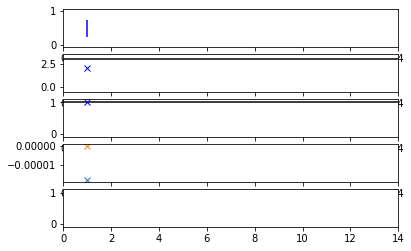

In [12]:
N=100 #interestingly the behavior depends heaviliy on the number of points
x = np.linspace(0,1,N)
dx = x[1]-x[0]
u0 = np.zeros_like(x)
u0[int(N/2)] = 1
#dt = 0.7*dx**2
dt = 0.0007847599703514606

A_heat = 1/dx**2 * (-2*np.diag(np.ones(N))+np.diag(np.ones(N-1),-1)+np.diag(np.ones(N-1),1))


#t, u, b = RK_variable_b_implicit(ex8,dt,f_heat,w0=u0,t_final=1.1,solver_eqs =solver_nonlinear_arg,
#                                 b_fixed=True,solver=cp.SCS)



solver = Solver(rkm = ex3,
               dt = dt,
               t_final = 0.01,
               b_fixed=False,
               tol_neg=1e-8,
               tol_change = np.inf,
               p = [3,2,1],
               theta = [1],
               solver = cp.MOSEK,
               solver_eqs=solver_Matrix,
               LP_opts = {'reduce':True})

problem_ADR = Problem(f=A_heat,
                 u0=u0,
                 minval=0,
                 maxval=np.inf)


status,t,u,b,KK = RK_integrate(solver=solver,problem=problem_ADR,verbose=True,dumpK=True)

t_ref = np.array(t)
u_ref = np.array(u).T
b_ref = np.array(b).T
utils.show_status(status)

#t, u, b = RK_convex_implicit(ex3,B,w,dt,A_heat,w0=u0,t_final=0.01,solver_eqs =solver_Matrix,
#                                 b_fixed=False,solver=cp.SCS,fallback = True)

#print('ref:')

#t_ref, u_ref, b_ref = RK_variable_b_implicit(ex3,dt,A_heat,w0=u0,t_final=0.01,solver_eqs =solver_Matrix,
#                                 b_fixed=True,solver=cp.SCS,fallback = True)


u_ex = scipy.linalg.expm(dt*A_heat)@u0

set up, starting to solve
calculation new set of stagevalues for t = 0 dt= 0.0007847599703514606
changed
Try: Order= 3 Theta= 1


array([[ 0.5       ,  0.87332328,  0.12667672,  0.75452072,  0.24547928],
       [-2.        , -3.35313268, -0.64686732, -1.34140466, -2.65859534],
       [-2.        , -2.81672679, -1.18327321, -3.34738056, -0.65261944],
       [ 1.5       ,  2.00742476,  0.99257524,  1.25302675,  1.74697325],
       [ 1.5       ,  2.51484951,  0.48515049,  1.00605349,  1.99394651],
       [ 1.5       ,  1.77426192,  1.22573808,  2.67518426,  0.32481574]])

Solver crashed
LP-Solve failed, probably infeasibel
Try: Order= 2 Theta= 1


array([[ 0.5       ,  0.87332328,  0.12667672,  0.75452072,  0.24547928,
        -0.5       ],
       [-2.        , -3.35313268, -0.64686732, -1.34140466, -2.65859534,
        -1.        ],
       [-2.        , -2.81672679, -1.18327321, -3.34738056, -0.65261944,
        -0.5       ],
       [ 1.5       ,  2.00742476,  0.99257524,  1.25302675,  1.74697325,
         1.        ],
       [ 1.5       ,  2.51484951,  0.48515049,  1.00605349,  1.99394651,
         1.        ],
       [ 1.5       ,  1.77426192,  1.22573808,  2.67518426,  0.32481574,
         1.        ]])

Solver crashed
LP-Solve failed, probably infeasibel
Try: Order= 1 Theta= 1


array([[ 0.5       ,  0.87332328,  0.12667672,  0.75452072,  0.24547928,
        -0.5       ,  0.        ],
       [-2.        , -3.35313268, -0.64686732, -1.34140466, -2.65859534,
        -1.        ,  0.        ],
       [-2.        , -2.81672679, -1.18327321, -3.34738056, -0.65261944,
        -0.5       ,  0.        ],
       [ 1.5       ,  2.00742476,  0.99257524,  1.25302675,  1.74697325,
         1.        ,  0.33333333],
       [ 1.5       ,  2.51484951,  0.48515049,  1.00605349,  1.99394651,
         1.        ,  0.33333333],
       [ 1.5       ,  1.77426192,  1.22573808,  2.67518426,  0.32481574,
         1.        ,  0.33333333]])

found new b
advancing t
calculation new set of stagevalues for t = 0.0007847599703514606 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.0015695199407029213 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.002354279911054382 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.0031390398814058426 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.003923799851757303 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.004708559822108764 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.005493319792460225 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.006278079762811686 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.007062839733163147 dt= 0.0007847599703514606
advancing t
calculation new set of stagevalues for t = 0.0078475997

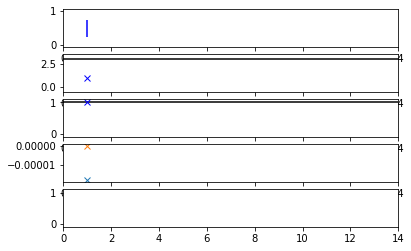

In [13]:
status,t,u,b,KK = RK_integrate_convex(solver=solver,problem=problem_ADR,verbose=True,dumpK=True)

t_con = np.array(t)
u_con = np.array(u).T
b_con = np.array(b).T
utils.show_status(status)

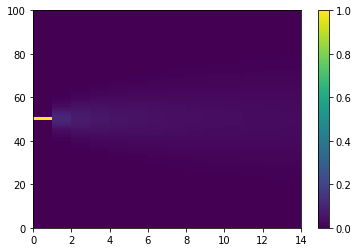

In [14]:
plt.pcolor(u_con)
plt.colorbar()

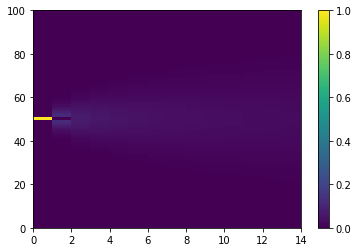

In [15]:
plt.pcolor(u_ref)
plt.colorbar()

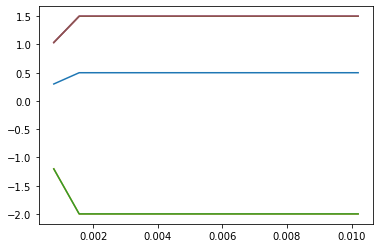

In [16]:
plt.plot(t[1:],b_con.T[1:,:]);

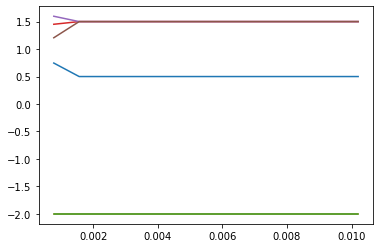

In [17]:
plt.plot(t[1:],b_ref.T[1:,:]);

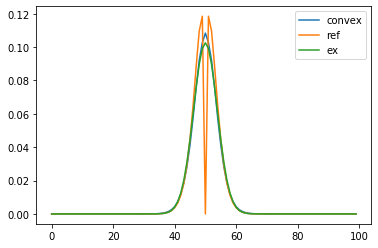

In [18]:
n=1
plt.plot(u_con[:,n],label='convex')
plt.plot(u_ref[:,n],label='ref')
plt.plot(u_ex,label='ex')
plt.legend()

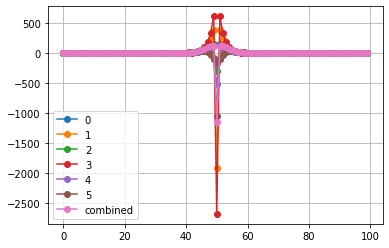

In [19]:
for i in range(6):
    plt.plot(KK[1][:,i],'-o',label=str(i))
#plt.ylim([-0.1,0.1])
plt.plot(KK[1]@ex3.b,'-o',label='combined')
plt.grid()
plt.legend()

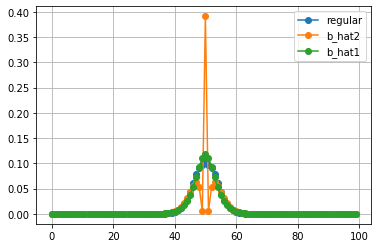

In [20]:
#plot the differnet options for the first step
plt.plot(u0 + dt*KK[1]@ex3.b,'-o',label='regular')
plt.plot(u0 + dt*KK[1]@b_hat_2[0],'-o',label='b_hat2')
plt.plot(u0 + dt*KK[1]@b_hat_1[0],'-o',label='b_hat1')
plt.grid()
plt.legend()

#plt.ylim([-0.005,0.005])

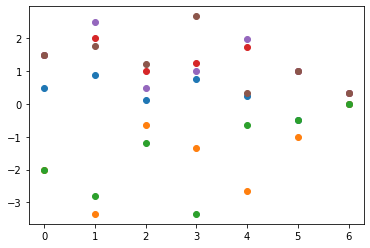

In [21]:
rkm = ex3
B = [[rkm.b]]
w = [0]
for order in range(rkm.p,0,-1):
    B.append(rkm.b_hat[order])
    w.extend([1/order]*len(rkm.b_hat[order]))
                
B = np.concatenate(B).T
n = np.arange(0,B.shape[1]) #only for plotting
plt.plot(n,B.T,'o')

In [23]:
print(b_hat_3)

[array([ 0.87332328, -3.35313268, -2.81672679,  2.00742476,  2.51484951,
        1.77426192]), array([ 0.12667672, -0.64686732, -1.18327321,  0.99257524,  0.48515049,
        1.22573808]), array([ 0.75452072, -1.34140466, -3.34738056,  1.25302675,  1.00605349,
        2.67518426]), array([ 0.24547928, -2.65859534, -0.65261944,  1.74697325,  1.99394651,
        0.32481574])]


In [28]:
b_hat_3 = [np.array([ 0.87332328, -3.35313268, -2.81672679,  2.00742476,  2.51484951,1.77426192]), 
 np.array([ 0.12667672, -0.64686732, -1.18327321,  0.99257524,  0.48515049,1.22573808]), 
 np.array([ 0.75452072, -1.34140466, -3.34738056,  1.25302675,  1.00605349,2.67518426]), 
 np.array([ 0.24547928, -2.65859534, -0.65261944,  1.74697325,  1.99394651,0.32481574])]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

The stability region is unbounded
[ 4.44089210e-16 -3.33333361e-09 -4.44444465e-09  1.38888878e-09]
The stability region is unbounded
[-2.22044605e-16  3.33333317e-09  4.44444431e-09 -1.38888889e-09]
The stability region is unbounded
[0.00000000e+00 0.00000000e+00 5.55555768e-10 8.33333069e-10]
The stability region is unbounded
[-4.44089210e-16 -2.22044605e-16 -5.55555546e-10 -8.33333291e-10]


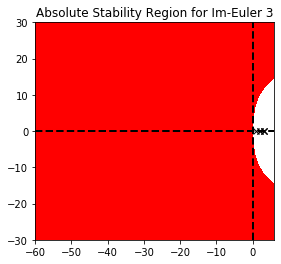

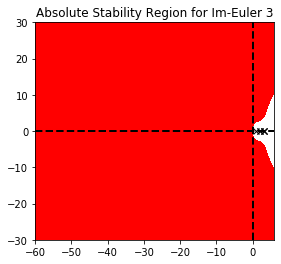

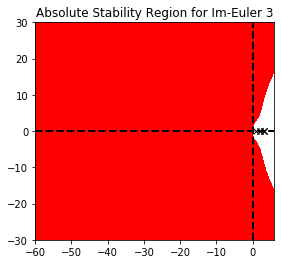

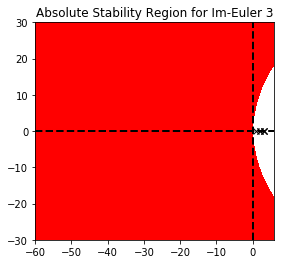

In [33]:
Q,rhs = OrderCond(ex3.A,ex3.c,order=3)

for i in range(len(b_hat_3)):
    ex3.b = b_hat_3[i]
    ex3.plot_stability_region()
    print(Q@ex3.b-rhs)